# Forecasting Indonesia's Youth Unemployment Rate

importing libraries and data

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [327]:
df = pd.read_csv('../data_ind_youth.csv')

In [328]:
# converting to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
# sorting order chronologically
df = df.sort_values('year_month').reset_index(drop=True)

### exploratory analysis

#### descriptive statistics

In [329]:
# descriptive statistics
df.describe()

,year_month,Unemployment_Rate
count,34,34.000000
mean,2016-05-02 00:00:00,14.615368
min,2008-02-01 00:00:00,11.812190
25%,2012-03-17 12:00:00,13.048628
50%,2016-05-02 00:00:00,14.249481
75%,2020-06-16 12:00:00,15.957687
max,2024-08-01 00:00:00,18.374399
std,NaN,1.826307


### trends and volatility

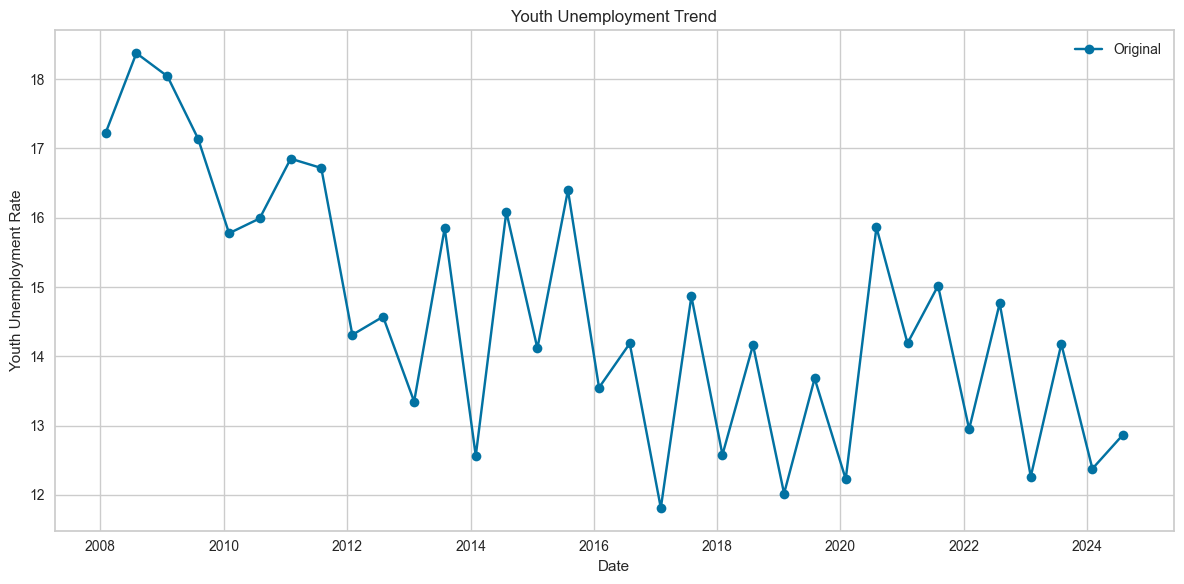

In [330]:
plt.figure(figsize=(12,6))
plt.plot(df['year_month'], df['Unemployment_Rate'], label='Original', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [331]:
# adding moving averages (2-period and 4-period) to see smoother trends
df_copy = df.copy()
df_copy['MA_2'] = df_copy['Unemployment_Rate'].rolling(window=2).mean()
df_copy['MA_4'] = df_copy['Unemployment_Rate'].rolling(window=4).mean()

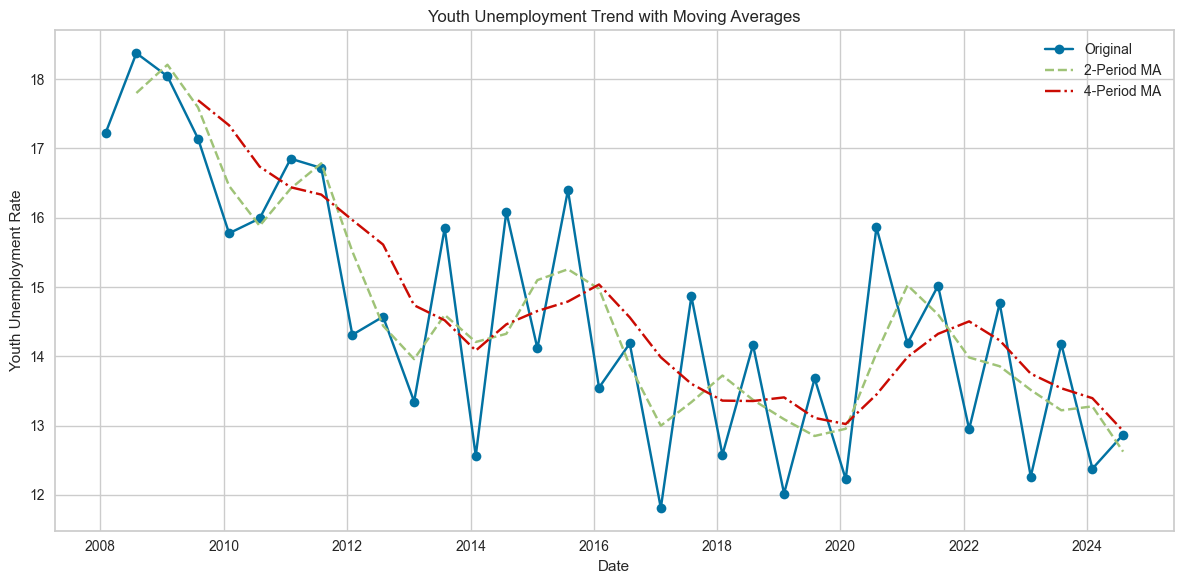

In [332]:
plt.figure(figsize=(12,6))
plt.plot(df_copy['year_month'], df_copy['Unemployment_Rate'], label='Original', marker='o')
plt.plot(df_copy['year_month'], df_copy['MA_2'], label='2-Period MA', linestyle='--')
plt.plot(df_copy['year_month'], df_copy['MA_4'], label='4-Period MA', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### decomposition

In [333]:
from statsmodels.tsa.seasonal import STL

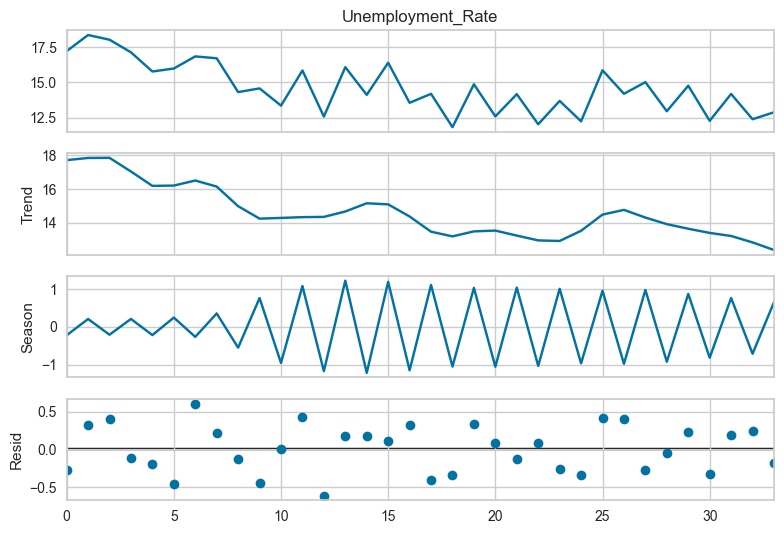

In [334]:
stl = STL(df["Unemployment_Rate"], period=2)  # 2 because it's semiannual
stl_result = stl.fit()
stl_result.plot()
plt.tight_layout()
plt.show()

#### seasonality

In [335]:
df_copy['month'] = df_copy['year_month'].dt.month
df_copy['year'] = df_copy['year_month'].dt.year

<Axes: xlabel='month', ylabel='Unemployment_Rate'>

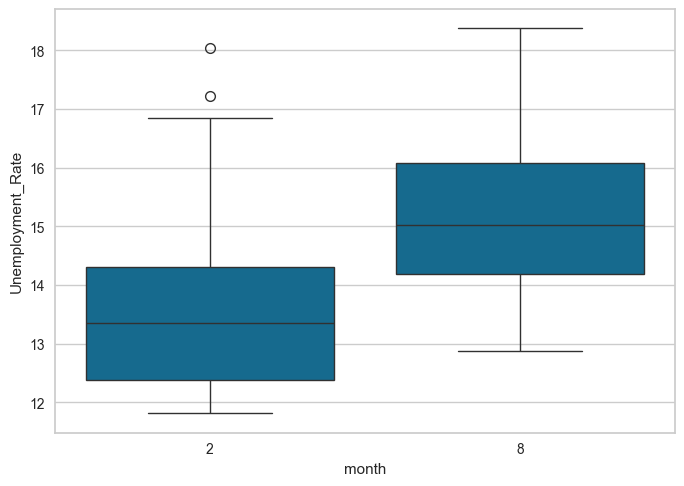

In [336]:
sns.boxplot(x='month', y='Unemployment_Rate', data=df_copy)

In [337]:
pivot_df = df_copy.pivot(index='year', columns='month', values='Unemployment_Rate')
pivot_df.columns = ['Feb', 'Aug']

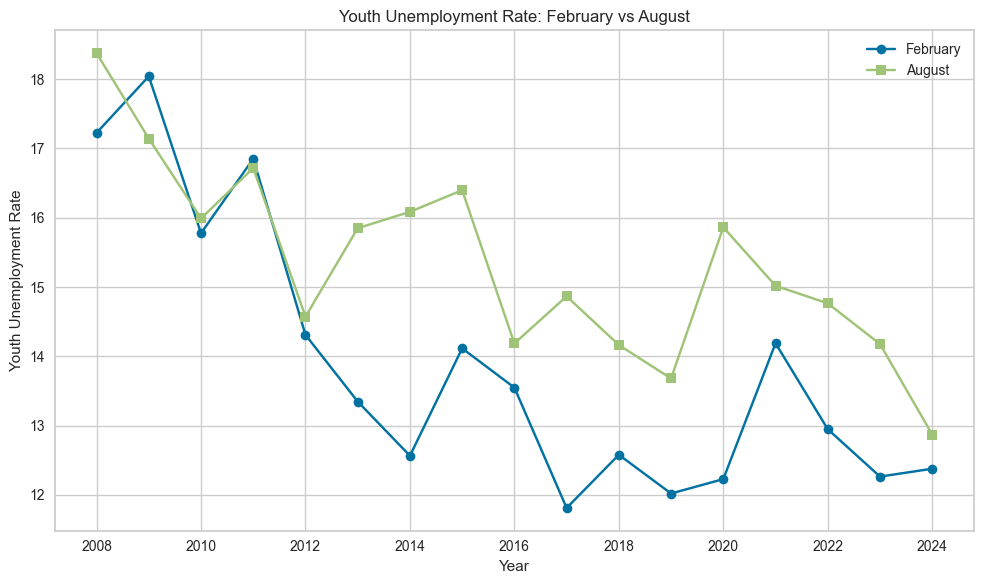

In [338]:
plt.figure(figsize=(10,6))
plt.plot(pivot_df.index, pivot_df['Feb'], label='February', marker='o')
plt.plot(pivot_df.index, pivot_df['Aug'], label='August', marker='s')
plt.xlabel('Year')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Rate: February vs August')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### stationarity

In [339]:
from statsmodels.tsa.stattools import adfuller

In [340]:
adf_test = adfuller(df['Unemployment_Rate'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# if p-value > 0.05, series is non-stationary → difference the series

ADF Statistic: -1.9510270770585783
p-value: 0.3084498727851944


differencing

In [341]:
# first difference of the series
df_copy['Unemployment_Diff_1'] = df_copy['Unemployment_Rate'].diff()

# Drop the first row (NaN after differencing)
df_diff = df_copy.dropna(subset=['Unemployment_Diff_1'])

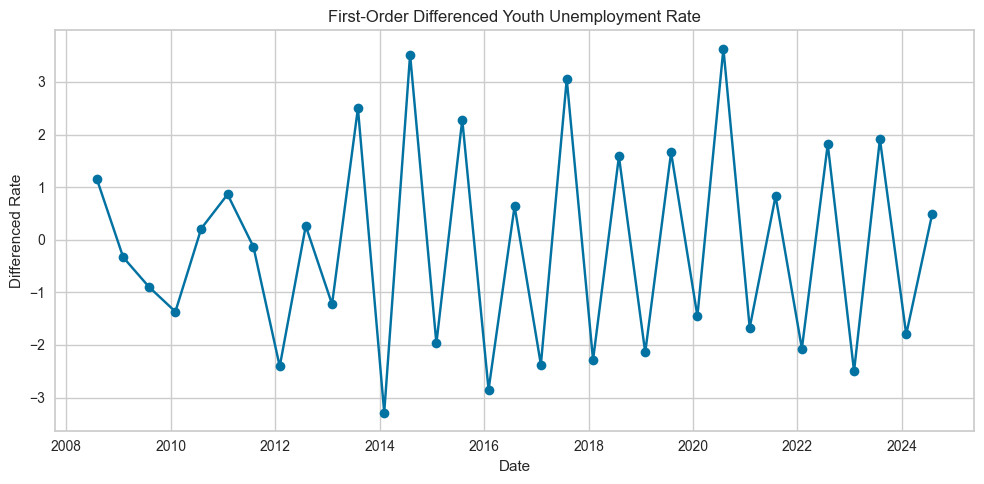

In [342]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff['year_month'], df_diff['Unemployment_Diff_1'], marker='o')
plt.title('First-Order Differenced Youth Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [343]:
adf_test_diff_1 = adfuller(df_diff['Unemployment_Diff_1'])
print(f"ADF Statistic: {adf_test_diff_1[0]}")
print(f"p-value: {adf_test_diff_1[1]}")

ADF Statistic: -5.487492241776113
p-value: 2.213091090741889e-06


#### autocorrelation (ACF) & partial autocorrelation (PACF)

In [344]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

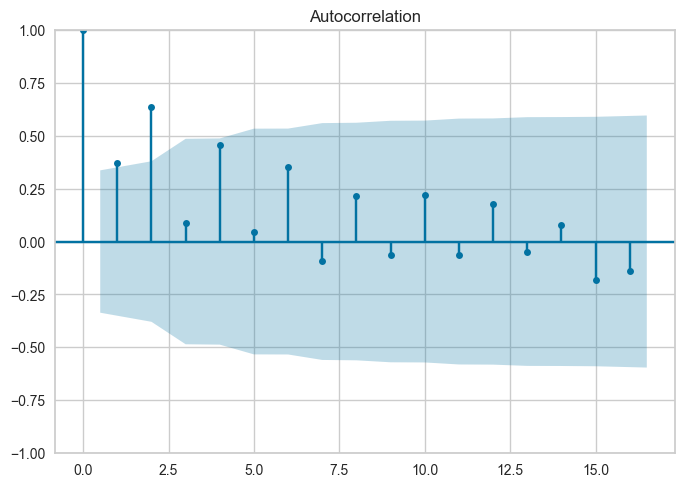

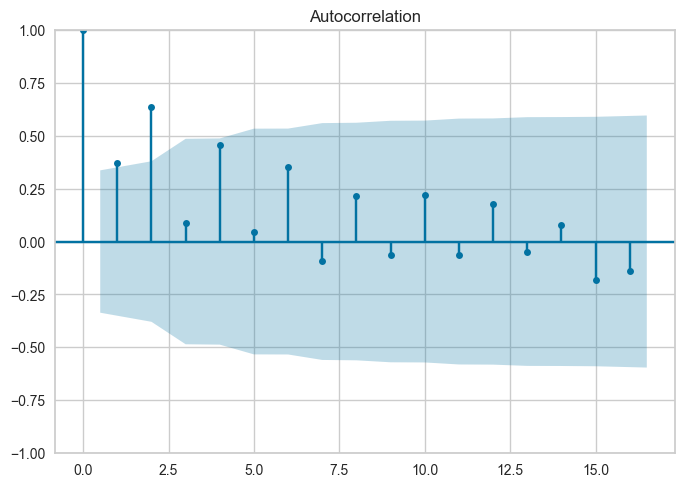

In [345]:
plot_acf(df['Unemployment_Rate'])
# shows pattern, slow decay suggests non-stationarity

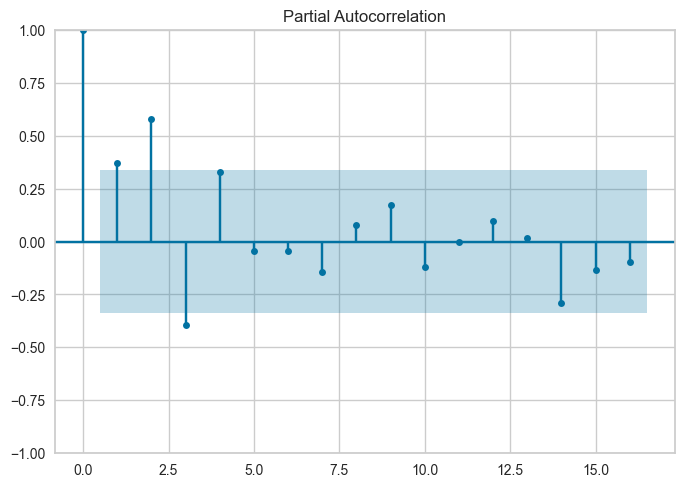

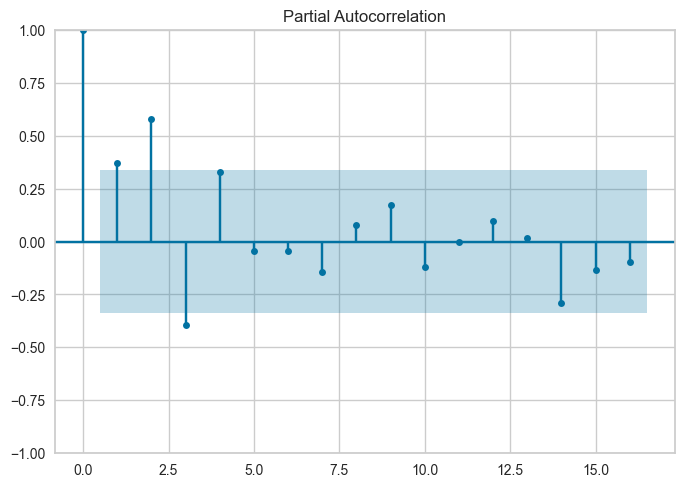

In [346]:
plot_pacf(df['Unemployment_Rate'])
# lags 1, 2, 3, 4 (spikes) are important in modeling the udnerlying data

#### trend smoothness

In [347]:
window_size = 2

df_copy['rolling_mean'] = df_copy['Unemployment_Rate'].rolling(window=window_size).mean()
df_copy['rolling_std'] = df_copy['Unemployment_Rate'].rolling(window=window_size).std()

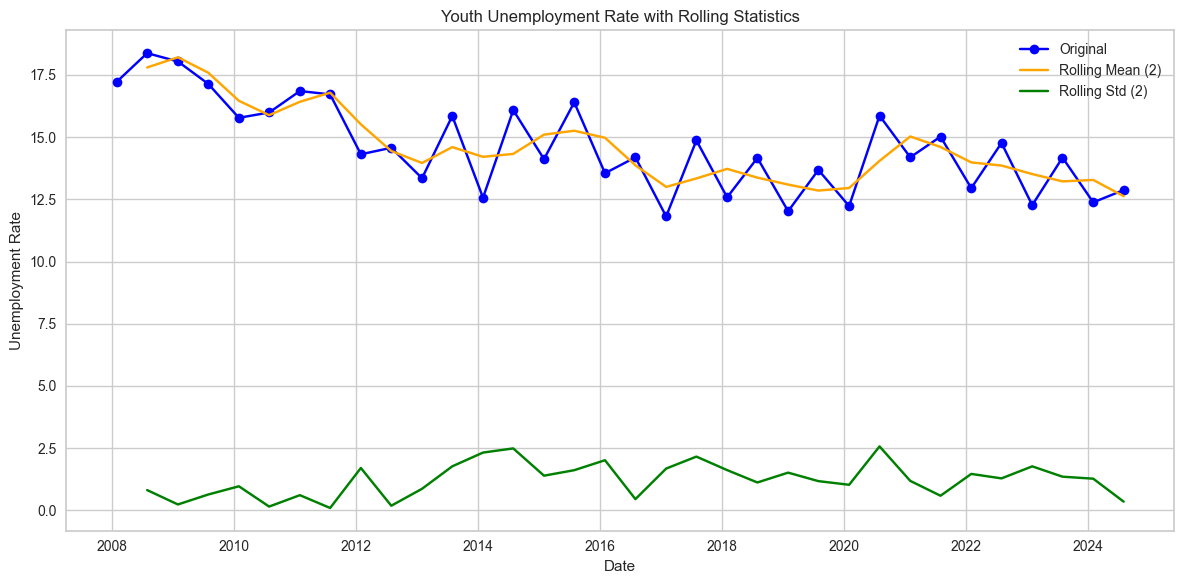

In [348]:
plt.figure(figsize=(12,6))
plt.plot(df_copy['year_month'], df_copy['Unemployment_Rate'], label='Original', color='blue', marker='o')
plt.plot(df_copy['year_month'], df_copy['rolling_mean'], label=f'Rolling Mean ({window_size})', color='orange')
plt.plot(df_copy['year_month'], df_copy['rolling_std'], label=f'Rolling Std ({window_size})', color='green')
plt.title('Youth Unemployment Rate with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [349]:
window_size = 2

df_copy['rolling_mean_diff'] = df_copy['Unemployment_Diff_1'].rolling(window=window_size).mean()
df_copy['rolling_std_diff'] = df_copy['Unemployment_Diff_1'].rolling(window=window_size).std()

df_diff_plot = df_copy.dropna(subset=['rolling_mean_diff', 'rolling_std_diff'])

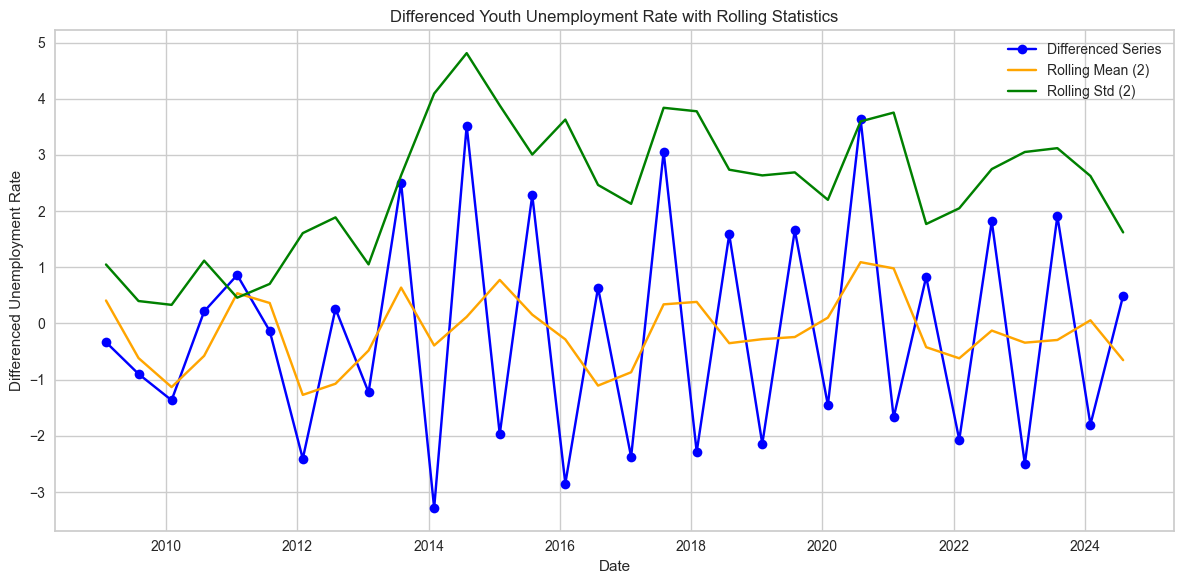

In [350]:
plt.figure(figsize=(12,6))
plt.plot(df_diff_plot['year_month'], df_diff_plot['Unemployment_Diff_1'], label='Differenced Series', color='blue', marker='o')
plt.plot(df_diff_plot['year_month'], df_diff_plot['rolling_mean_diff'], label=f'Rolling Mean ({window_size})', color='orange')
plt.plot(df_diff_plot['year_month'], df_diff_plot['rolling_std_diff'], label=f'Rolling Std ({window_size})', color='green')
plt.title('Differenced Youth Unemployment Rate with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Differenced Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### outlier detection

In [351]:
from scipy.stats import zscore

In [352]:
# calculate Z-score for the unemployment rate
df_copy['z_score'] = zscore(df_copy['Unemployment_Rate'])

# set threshold (usually 3 or -3)
threshold = 3

# identify outliers (those where |z_score| > threshold)
outliers = df_copy[abs(df_copy['z_score']) > threshold]

In [353]:
print(outliers[['year_month', 'Unemployment_Rate', 'z_score']])

Empty DataFrame
Columns: [year_month, Unemployment_Rate, z_score]
Index: []


or

In [354]:
Q1 = df_copy['Unemployment_Rate'].quantile(0.25)
Q3 = df_copy['Unemployment_Rate'].quantile(0.75)
IQR = Q3 - Q1

# set outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df_copy[(df_copy['Unemployment_Rate'] < lower_bound) | (df_copy['Unemployment_Rate'] > upper_bound)]

In [355]:
print(outliers_iqr[['year_month', 'Unemployment_Rate']])

Empty DataFrame
Columns: [year_month, Unemployment_Rate]
Index: []


#### distribution

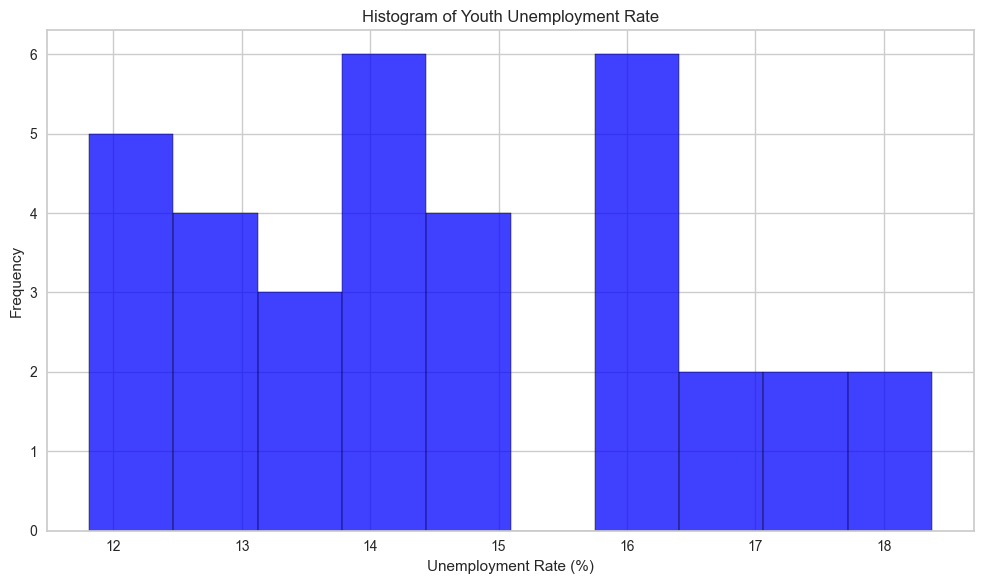

In [356]:
plt.figure(figsize=(10,6))
sns.histplot(df['Unemployment_Rate'], kde=False, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Youth Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

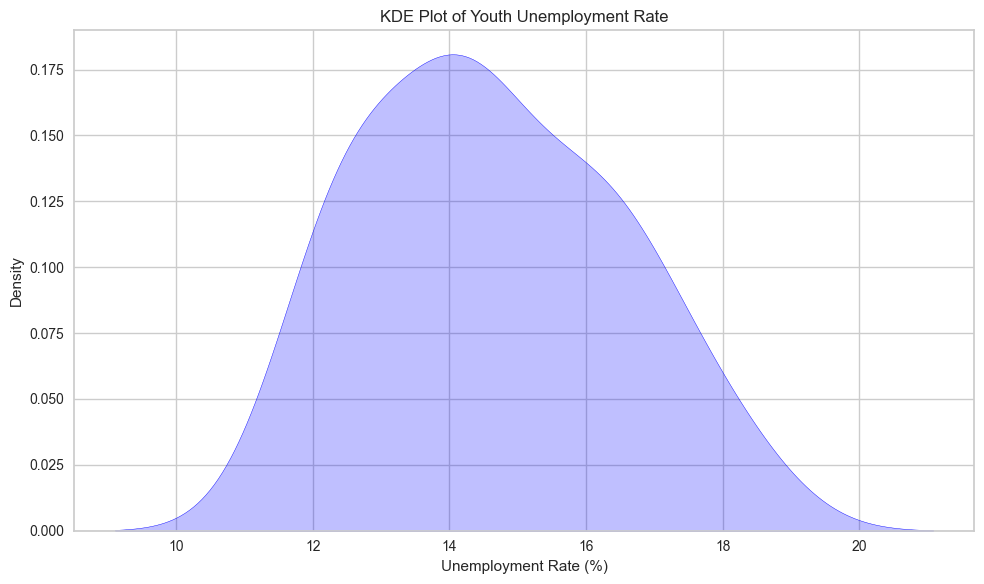

In [357]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['Unemployment_Rate'], color='blue', fill=True)
plt.title('KDE Plot of Youth Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

In [358]:
# skewness
df['Unemployment_Rate'].skew()
# 0.2948276004632729 -> slightly positively skewed

0.2948276004632729

### forecasting

general first test with pycaret

In [359]:
df_forecast = df.copy()
df_forecast.set_index('year_month', inplace=True)

df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.index = pd.period_range(start=df_forecast.index[0], periods=len(df_forecast), freq='2Q')

In [360]:
from pycaret.time_series import *
import numpy as np

In [361]:
exp = setup(data=df_forecast, target='Unemployment_Rate', fh = 6, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(34, 1)"
5,Transformed data shape,"(34, 1)"
6,Transformed train set shape,"(28, 1)"
7,Transformed test set shape,"(6, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [362]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,34.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,14.615368
3,Summary,Statistics,Transformed,Median,,14.249481
4,Summary,Statistics,Transformed,Standard Deviation,,1.826307
5,Summary,Statistics,Transformed,Variance,,3.335398
6,Summary,Statistics,Transformed,Kurtosis,,-0.857332
7,Summary,Statistics,Transformed,Skewness,,0.294828
8,Summary,Statistics,Transformed,# Distinct Values,,34.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",68.190447


In [363]:
best_model = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8330,0.9551,1.0920,1.4067,0.0743,0.0779,-0.1589,0.0400
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8409,0.9835,1.1013,1.4448,0.0746,0.0789,-0.2393,0.0467
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9436,1.0214,1.2417,1.5066,0.0847,0.0890,-0.3301,0.0867
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9632,1.0380,1.2737,1.5300,0.0869,0.0916,-0.3866,0.0633
theta,Theta Forecaster,0.9769,1.0526,1.2820,1.5464,0.0888,0.0913,-0.4254,0.0167
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.0302,1.1336,1.3261,1.6492,0.0910,0.0962,-0.6565,0.0400
exp_smooth,Exponential Smoothing,1.0487,1.1314,1.3759,1.6604,0.0932,0.0997,-0.6452,0.0200
ets,ETS,1.0487,1.1314,1.3759,1.6605,0.0932,0.0997,-0.6452,0.0200
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.0521,1.1315,1.3771,1.6599,0.0938,0.0996,-0.6527,0.1567
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.0598,1.1344,1.3861,1.6645,0.0944,0.1003,-0.6612,0.1167


In [364]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [365]:
exp.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 2]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)

In [366]:
exp.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

In [367]:
exp.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})
exp.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

individual models and fine-tuning

In [368]:
# gbr_cds_dt
gbr_cds_dt = exp.create_model("gbr_cds_dt")
y_predict_gbr_cds_dt = exp.predict_model(gbr_cds_dt)
exp.plot_model(estimator=gbr_cds_dt)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:43:24
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting w/ Cond. Deseasonalize & Det...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9606,1.1173,1.4358,1.8271,0.0943,0.0979,-0.5596
1,2015Q3,0.4294,0.5628,0.5238,0.7833,0.0379,0.0395,0.4310
2,2018Q3,1.1089,1.1851,1.3164,1.6096,0.0907,0.0962,-0.3481
Mean,NaT,0.8330,0.9551,1.0920,1.4067,0.0743,0.0779,-0.1589
SD,NaT,0.2917,0.2787,0.4047,0.4496,0.0258,0.0271,0.4260


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,GradientBoostingRegressor,0.3967,0.4480,0.4574,0.6011,0.0357,0.0346,0.5764


In [369]:
tuned_gbr_cds_dt = exp.tune_model(gbr_cds_dt)
exp.plot_model(estimator=tuned_gbr_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2821,1.3323,1.9164,2.1787,0.1261,0.1335,-1.2175
1,2015Q3,0.7662,0.7894,0.9347,1.0987,0.0698,0.0700,-0.1193
2,2018Q3,1.4889,1.6530,1.7675,2.2449,0.1197,0.1315,-1.6226
Mean,NaT,1.1791,1.2582,1.5395,1.8408,0.1052,0.1116,-0.9865
SD,NaT,0.3039,0.3564,0.4320,0.5254,0.0252,0.0295,0.6351


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


In [373]:
print(gbr_cds_dt)
print(tuned_gbr_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=GradientBoostingRegressor(random_state=123), sp=2,
                    window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=GradientBoostingRegressor(random_state=123), sp=2,
                    window_length=2)


In [371]:
exp.plot_model([gbr_cds_dt, tuned_gbr_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [77]:
# ada_cds_dt
ada_cds_dt = exp.create_model("ada_cds_dt")
y_predict_ada_cds_dt = exp.predict_model(ada_cds_dt)
exp.plot_model(estimator=ada_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9629,1.1207,1.4392,1.8327,0.0945,0.0981,-0.5691
1,2015Q3,0.3973,0.4967,0.4847,0.6913,0.0352,0.0365,0.5569
2,2018Q3,1.1625,1.3330,1.3801,1.8104,0.0939,0.1020,-0.7055
Mean,NaT,0.8409,0.9835,1.1013,1.4448,0.0746,0.0789,-0.2393
SD,NaT,0.3241,0.3549,0.4367,0.5329,0.0278,0.0300,0.5657


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,AdaBoostRegressor,0.5393,0.5628,0.6218,0.7551,0.0478,0.0462,0.3314


In [78]:
tuned_ada_cds_dt = exp.tune_model(ada_cds_dt)
exp.plot_model(estimator=tuned_ada_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9606,1.1173,1.4358,1.8271,0.0943,0.0979,-0.5596
1,2015Q3,0.8596,0.9228,1.0485,1.2843,0.0755,0.0777,-0.5293
2,2018Q3,1.1641,1.2949,1.3819,1.7587,0.0943,0.1017,-0.6096
Mean,NaT,0.9947,1.1117,1.2887,1.6234,0.0880,0.0924,-0.5662
SD,NaT,0.1266,0.1520,0.1713,0.2414,0.0089,0.0105,0.0331


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished


In [372]:
print(ada_cds_dt)
print(tuned_ada_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=123), sp=2,
                    window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=123), sp=2,
                    window_length=2)


In [79]:
exp.plot_model([ada_cds_dt, tuned_ada_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [81]:
# rf_cds_dt
rf_cds_dt = exp.create_model("rf_cds_dt")
y_predict_rf_cds_dt = exp.predict_model(rf_cds_dt)
exp.plot_model(estimator=rf_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1170,1.2043,1.6695,1.9694,0.1099,0.1148,-0.8119
1,2015Q3,0.6423,0.7194,0.7835,1.0013,0.0569,0.0597,0.0704
2,2018Q3,1.0716,1.1406,1.2721,1.5492,0.0873,0.0925,-0.2489
Mean,NaT,0.9436,1.0214,1.2417,1.5066,0.0847,0.0890,-0.3301
SD,NaT,0.2139,0.2151,0.3624,0.3964,0.0217,0.0226,0.3648


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,RandomForestRegressor,0.3862,0.4621,0.4453,0.6199,0.0348,0.0337,0.5494


In [82]:
tuned_rf_cds_dt = exp.tune_model(rf_cds_dt)
exp.plot_model(estimator=tuned_rf_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.0829,1.2001,1.6186,1.9625,0.1070,0.1113,-0.7992
1,2015Q3,0.8367,0.8105,1.0206,1.1280,0.0737,0.0759,-0.1799
2,2018Q3,1.5176,1.6512,1.8015,2.2425,0.1228,0.1353,-1.6170
Mean,NaT,1.1457,1.2206,1.4802,1.7777,0.1011,0.1075,-0.8654
SD,NaT,0.2815,0.3435,0.3335,0.4734,0.0205,0.0244,0.5886


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


In [374]:
print(rf_cds_dt)
print(tuned_rf_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=RandomForestRegressor(n_jobs=-1, random_state=123),
                    sp=2, window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=RandomForestRegressor(n_jobs=-1, random_state=123),
                    sp=2, window_length=2)


In [ ]:
exp.plot_model([rf_cds_dt, tuned_rf_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [85]:
exp_smooth = exp.create_model("exp_smooth")
y_predict_exp_smooth = exp.predict_model(exp_smooth)
exp.plot_model(estimator=exp_smooth)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2239,1.2739,1.8294,2.0832,0.1197,0.1277,-1.0274
1,2015Q3,0.5009,0.5518,0.6110,0.7680,0.0453,0.0457,0.4530
2,2018Q3,1.4212,1.5684,1.6872,2.1301,0.1145,0.1257,-1.3611
Mean,NaT,1.0487,1.1314,1.3759,1.6604,0.0932,0.0997,-0.6452
SD,NaT,0.3956,0.4271,0.5439,0.6313,0.0339,0.0382,0.7884


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.4812,0.5389,0.5549,0.7230,0.0426,0.0411,0.3870


In [86]:
tuned_exp_smooth = exp.tune_model(exp_smooth)
exp.plot_model(estimator=tuned_exp_smooth)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.7614,0.7573,1.1381,1.2383,0.0778,0.0778,0.2836
1,2015Q3,0.6842,0.7256,0.8346,1.0099,0.0648,0.0617,0.0543
2,2018Q3,0.8578,0.8789,1.0183,1.1936,0.0708,0.0735,0.2586
Mean,NaT,0.7678,0.7872,0.9970,1.1473,0.0711,0.0710,0.1988
SD,NaT,0.0710,0.0661,0.1248,0.0989,0.0053,0.0068,0.1027


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


In [375]:
print(exp_smooth)
print(tuned_exp_smooth)

ExponentialSmoothing(seasonal='mul', sp=2, trend='add')
ExponentialSmoothing(seasonal='add', sp=2, trend='mul', use_boxcox=False)


In [88]:
exp.plot_model([exp_smooth, tuned_exp_smooth], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [89]:
ets = exp.create_model("ets")
y_predict_ets = exp.predict_model(ets)
exp.plot_model(estimator=ets)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2240,1.2739,1.8294,2.0833,0.1197,0.1277,-1.0275
1,2015Q3,0.5009,0.5518,0.6110,0.7680,0.0453,0.0457,0.4530
2,2018Q3,1.4212,1.5684,1.6872,2.1301,0.1145,0.1257,-1.3612
Mean,NaT,1.0487,1.1314,1.3759,1.6605,0.0932,0.0997,-0.6452
SD,NaT,0.3956,0.4271,0.5439,0.6313,0.0339,0.0382,0.7884


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,0.4546,0.5151,0.5241,0.6910,0.0405,0.0391,0.4401


In [90]:
tuned_ets = exp.tune_model(ets)
exp.plot_model(estimator=tuned_ets)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1210,1.1409,1.6756,1.8657,0.1105,0.1161,-0.6261
1,2015Q3,0.4383,0.4307,0.5346,0.5994,0.0400,0.0400,0.6669
2,2018Q3,1.2671,1.4233,1.5042,1.9330,0.1024,0.1117,-0.9445
Mean,NaT,0.9421,0.9983,1.2381,1.4660,0.0843,0.0893,-0.3012
SD,NaT,0.3612,0.4176,0.5024,0.6134,0.0315,0.0349,0.6968


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


In [376]:
print(ets)
print(tuned_ets)

AutoETS(seasonal='mul', sp=2, trend='add')
AutoETS(error='mul', seasonal='add', sp=2, trend='mul')


In [92]:
exp.plot_model([ets, tuned_ets], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [93]:
arima = exp.create_model("arima")
y_predict_arima = exp.predict_model(arima)
exp.plot_model(estimator=arima)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.3945,1.5868,2.0844,2.5950,0.1334,0.1485,-2.1459
1,2015Q3,0.9592,0.9314,1.1701,1.2964,0.0876,0.0830,-0.5583
2,2018Q3,1.1744,1.3560,1.3942,1.8416,0.0949,0.1034,-0.7649
Mean,NaT,1.1761,1.2914,1.5496,1.9110,0.1053,0.1116,-1.1563
SD,NaT,0.1777,0.2714,0.3891,0.5324,0.0201,0.0273,0.7048


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.6755,0.6801,0.7788,0.9123,0.0613,0.0588,0.0240


In [ ]:
print(arima)

ARIMA(seasonal_order=(0, 1, 0, 2))


### baseline forecasting comparison with interpolated data

#### quarterly

In [150]:
df_quarter = df_forecast.copy()
df_quarter.index = pd.PeriodIndex(df_quarter.index.astype(str), freq='Q')
df_quarter.index.name = 'quarter'

full_index = pd.period_range(start=df_quarter.index.min(), end=df_quarter.index.max(), freq='Q')
df_quarter = df_quarter.reindex(full_index)

interpolate: linear

In [152]:
df_linear_q = df_quarter.interpolate(method='linear')

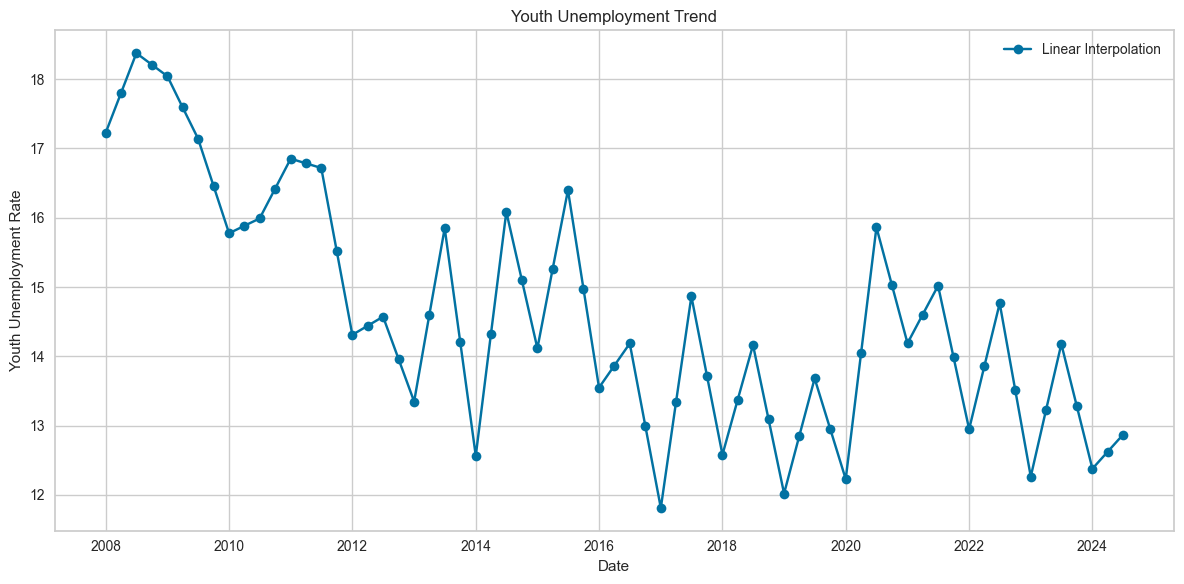

In [157]:
plt.figure(figsize=(12,6))
plt.plot(df_linear_q.index.to_timestamp(), df_linear_q['Unemployment_Rate'], label='Linear Interpolation', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
exp_int_lin = setup(data=df_linear_q, target='Unemployment_Rate', fh = 13, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(67, 1)"
5,Transformed data shape,"(67, 1)"
6,Transformed train set shape,"(54, 1)"
7,Transformed test set shape,"(13, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [160]:
best_model_int_lin = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ets,ETS,0.9848,1.0253,1.0629,1.3081,0.0753,0.0767,-0.7614,0.0233
theta,Theta Forecaster,1.0319,1.0888,1.1148,1.3844,0.0795,0.0776,-1.1064,0.0167
exp_smooth,Exponential Smoothing,1.0653,1.0853,1.1507,1.3788,0.0823,0.0798,-1.1846,0.0233
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.0718,1.1637,1.1597,1.4909,0.0803,0.0838,-1.0059,0.1967
stlf,STLF,1.1181,1.1365,1.2072,1.4414,0.0857,0.0834,-1.5851,0.3400
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.1969,1.2073,1.2935,1.5447,0.0912,0.0956,-1.2593,0.0567
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.2078,1.2180,1.3055,1.5589,0.0917,0.0960,-1.2731,0.1033
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.2136,1.2225,1.3119,1.5650,0.0920,0.0964,-1.2851,0.0533
snaive,Seasonal Naive Forecaster,1.2137,1.1656,1.3122,1.4808,0.0939,0.0891,-1.7375,0.3167
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.2244,1.3202,1.3247,1.6917,0.0918,0.0966,-1.5916,0.0900


In [161]:
exp_int_lin.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [162]:
exp_int_lin.plot_model(best_model_int_lin)

In [163]:
y_predict_best_int_lin = exp_int_lin.predict_model(best_model_int_lin)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,0.7648,0.6963,0.7790,0.8631,0.0595,0.0573,-0.0675


interpolate: spline

In [165]:
df_quarter.index = df_quarter.index.to_timestamp()

In [166]:
df_spline_q = df_quarter.interpolate(method='spline', order=3) # cubic

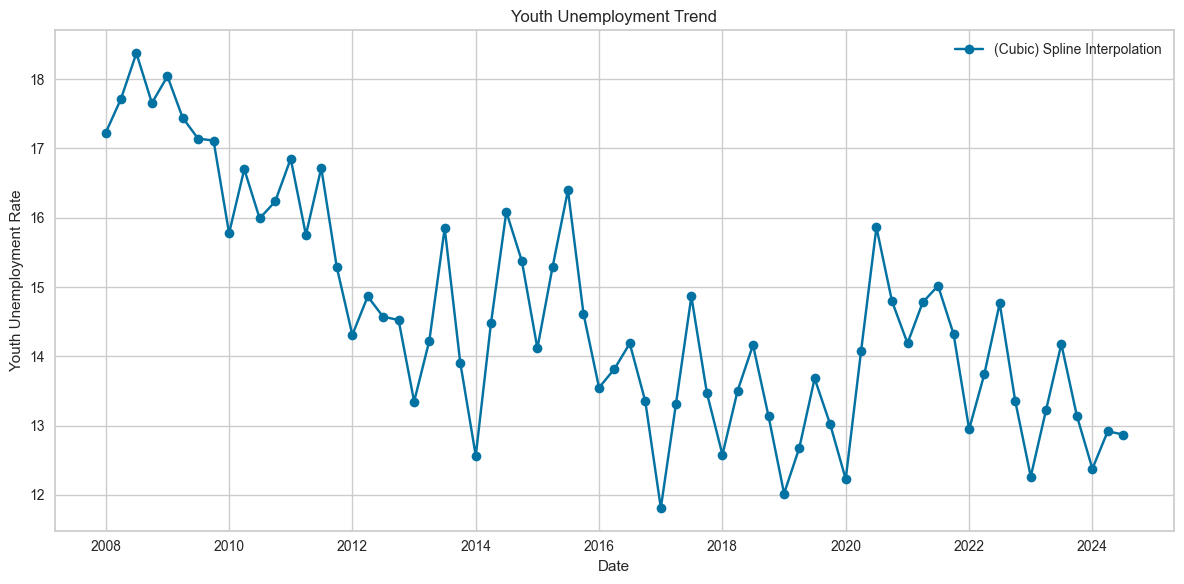

In [171]:
plt.figure(figsize=(12,6))
plt.plot(df_spline_q.index, df_spline_q['Unemployment_Rate'], label='(Cubic) Spline Interpolation', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
exp_int_spl = setup(data=df_spline_q, target='Unemployment_Rate', fh = 13, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(67, 1)"
5,Transformed data shape,"(67, 1)"
6,Transformed train set shape,"(54, 1)"
7,Transformed test set shape,"(13, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [173]:
best_model_int_spl = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ets,ETS,0.8579,0.9705,0.8473,1.0988,0.0592,0.0604,-0.2585,0.0233
stlf,STLF,1.0030,1.0992,0.9887,1.2365,0.0702,0.0696,-0.7220,0.0167
arima,ARIMA,1.0098,1.1416,0.9993,1.2917,0.0709,0.0721,-0.6429,0.0233
theta,Theta Forecaster,1.0318,1.1331,1.0180,1.2767,0.0727,0.0714,-0.7123,0.0133
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.0773,1.1872,1.0687,1.3499,0.0743,0.0769,-0.6748,0.1367
exp_smooth,Exponential Smoothing,1.1094,1.1776,1.1004,1.3396,0.0766,0.0795,-0.6586,0.0467
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.1488,1.2318,1.1400,1.4008,0.0795,0.0822,-0.8020,0.1400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.2238,1.3409,1.2154,1.5270,0.0848,0.0890,-1.2130,0.1333
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.2365,1.3419,1.2278,1.5286,0.0856,0.0899,-1.2156,0.0833
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.2482,1.3338,1.2390,1.5193,0.0864,0.0906,-1.1918,0.1033


In [174]:
exp_int_spl.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [176]:
exp_int_spl.plot_model(best_model_int_spl)

In [177]:
y_predict_best_int_spl = exp_int_spl.predict_model(best_model_int_spl)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,1.2220,1.1127,1.1817,1.2750,0.0886,0.0842,-1.3151


#### monthly

interpolate: linear

In [199]:
df_month = df.copy()
df_month['year_month'] = pd.to_datetime(df_month['year_month'])
df_month.set_index('year_month', inplace=True)

In [200]:
df_linear_m = df_month.resample('MS').interpolate(method='linear')

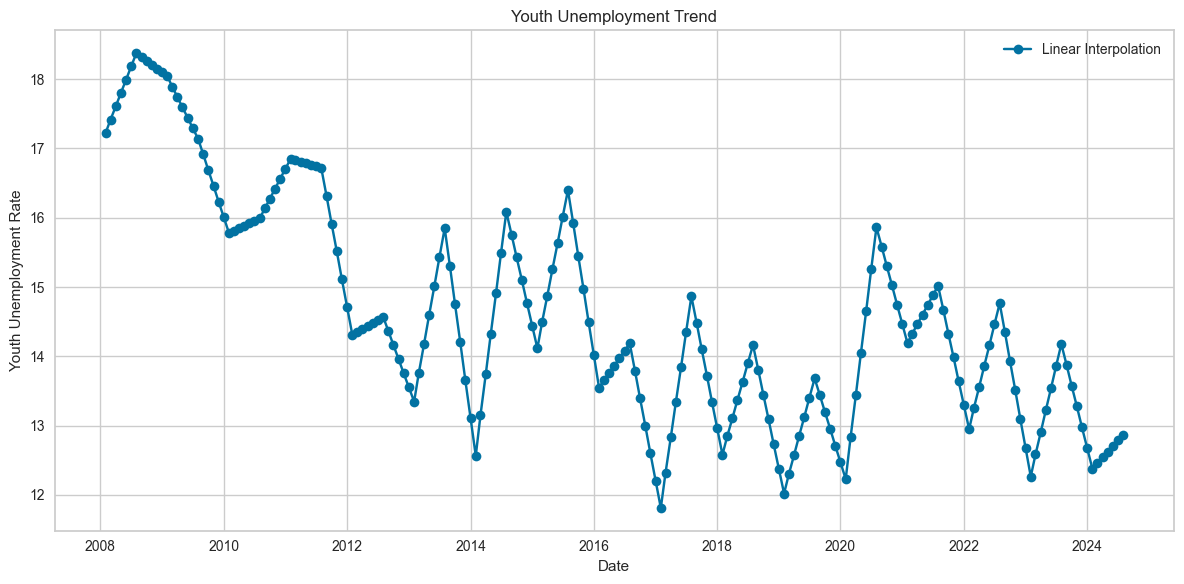

In [204]:
plt.figure(figsize=(12,6))
plt.plot(df_linear_m.index, df_linear_m['Unemployment_Rate'], label='Linear Interpolation', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [248]:
exp_int_lin_m = setup(data=df_linear_m, target='Unemployment_Rate', fh = 36, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(199, 1)"
5,Transformed data shape,"(199, 1)"
6,Transformed train set shape,"(163, 1)"
7,Transformed test set shape,"(36, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [249]:
best_model_int_lin_m = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9950,1.0227,1.1109,1.3542,0.0774,0.0801,-1.1319,0.2233
snaive,Seasonal Naive Forecaster,1.0132,0.9483,1.1082,1.2341,0.0799,0.0775,-0.9469,0.3333
croston,Croston,1.0167,0.9917,1.1105,1.2900,0.0815,0.0783,-1.0589,0.0100
auto_arima,Auto ARIMA,1.0170,1.0657,1.1088,1.3805,0.0778,0.0801,-1.1062,6.4833
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.1221,1.1607,1.2346,1.5163,0.0854,0.0914,-1.6422,0.1600
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.1279,1.1660,1.2411,1.5237,0.0860,0.0920,-1.6681,0.1433
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.1331,1.1697,1.2468,1.5285,0.0864,0.0925,-1.6814,0.2000
theta,Theta Forecaster,1.1417,1.1180,1.2505,1.4567,0.0887,0.0882,-1.5633,0.0200
polytrend,Polynomial Trend Forecaster,1.1518,1.2031,1.2679,1.5710,0.0870,0.0930,-1.7735,0.3200
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.1634,1.2037,1.2774,1.5720,0.0888,0.0943,-1.7714,0.3500


In [250]:
exp_int_lin_m.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [251]:
exp_int_lin_m.plot_model(best_model_int_lin_m)

In [252]:
y_predict_best_int_lin_m = exp_int_lin_m.predict_model(best_model_int_lin_m)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,LGBMRegressor,0.6011,0.5478,0.5918,0.6576,0.0451,0.0439,0.0921


interpolate: spline

In [208]:
df_spline_m = df_month.resample('MS').interpolate(method='spline', order=3) # cubic

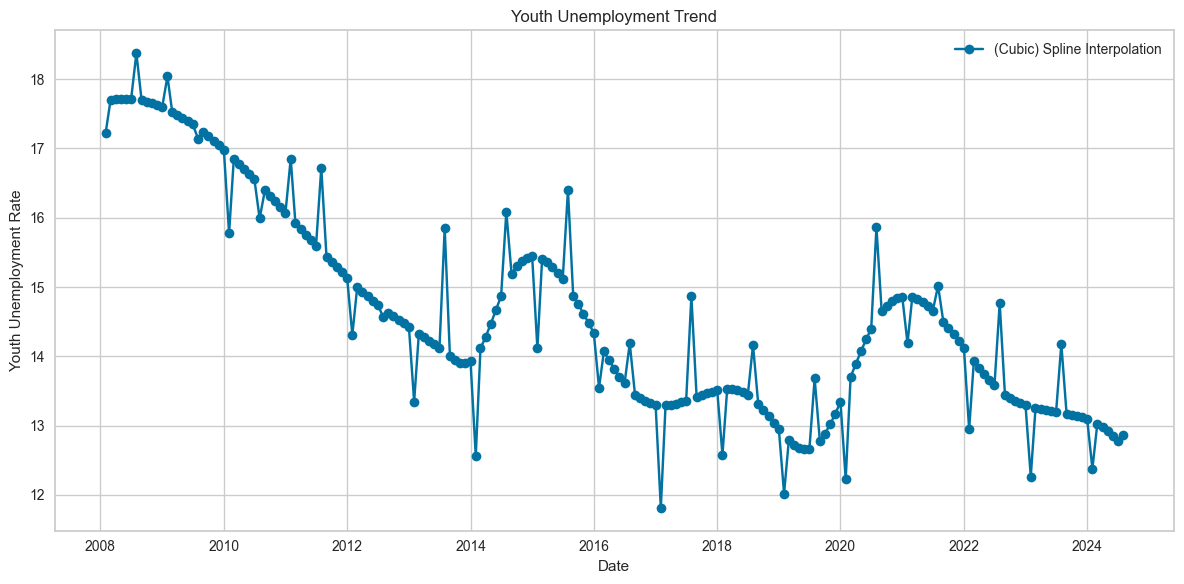

In [209]:
plt.figure(figsize=(12,6))
plt.plot(df_spline_m.index, df_spline_m['Unemployment_Rate'], label='(Cubic) Spline Interpolation', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [253]:
exp_int_spl_m = setup(data=df_spline_m, target='Unemployment_Rate', fh = 36, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(199, 1)"
5,Transformed data shape,"(199, 1)"
6,Transformed train set shape,"(163, 1)"
7,Transformed test set shape,"(36, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [254]:
best_model_int_spl_m = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,0.7237,0.7816,0.9911,1.1521,0.0705,0.0702,-1.5847,0.0167
arima,ARIMA,0.7612,0.9377,1.0471,1.3853,0.0724,0.0763,-2.1300,0.0467
snaive,Seasonal Naive Forecaster,0.7617,0.8393,1.0589,1.2451,0.0757,0.0734,-2.1403,0.0233
croston,Croston,0.7625,0.8062,1.0454,1.1881,0.0762,0.0734,-2.2335,0.0100
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.7869,0.9769,1.0817,1.4436,0.0743,0.0795,-2.4106,0.2800
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.7890,0.9756,1.0850,1.4422,0.0747,0.0797,-2.4395,0.2767
polytrend,Polynomial Trend Forecaster,0.7933,0.9695,1.0866,1.4308,0.0746,0.0800,-2.3189,0.0100
stlf,STLF,0.8117,0.9993,1.1138,1.4753,0.0772,0.0812,-2.5442,0.3900
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.8136,0.9841,1.1164,1.4526,0.0769,0.0823,-2.4237,0.5033
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.8176,1.0041,1.1177,1.4767,0.0768,0.0829,-2.5148,0.2900


In [255]:
exp_int_spl_m.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [256]:
exp_int_spl_m.plot_model(best_model_int_spl_m)

In [257]:
y_predict_best_int_spl_m = exp_int_spl_m.predict_model(best_model_int_spl_m)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Theta Forecaster,0.5487,0.5453,0.6582,0.7426,0.0499,0.0484,-0.6521


### Accuracy Comparison
Diebold-Mariano Test

In [ ]:
'''
from arch.bootstrap import dm_test
import pandas as pd
import numpy as np

def diebold_mariano_test(model1, model2, y_test, fh, power=2, h=1):
    """
    Perform Diebold-Mariano test on two PyCaret time series models.
    
    Parameters:
    - model1, model2: Finalized PyCaret time series models (e.g., from finalize_model()).
    - y_test: Series or array of true values (actuals) for the forecast horizon.
    - fh: Forecast horizon (e.g., 12).
    - power: Power of loss function. Default = 2 (squared error).
    - h: Forecast horizon lag. Default = 1.
    
    Returns:
    - Dictionary with DM statistic and p-value.
    """
    
    # Generate forecasts
    forecast1 = predict_model(model1, fh=fh)
    forecast2 = predict_model(model2, fh=fh)

    # Ensure y_test is aligned with forecasts
    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    errors1 = y_test - forecast1['y_pred'].values
    errors2 = y_test - forecast2['y_pred'].values

    # DM Test
    stat, p_value = dm_test(errors1, errors2, h=h, power=power)

    return {
        "DM_statistic": stat,
        "p_value": p_value,
        "better_model": "model2" if stat > 0 else "model1" if stat < 0 else "equal"
    }
'''

In [222]:
from dieboldmariano import dm_test

In [272]:
# fh = 6
y_predict_gbr_cds_dt = exp.predict_model(gbr_cds_dt) # biannual
y_predict_best_int_lin = exp_int_lin.predict_model(best_model_int_lin) # quarterly
y_predict_best_int_lin_m = exp_int_lin_m.predict_model(best_model_int_lin_m) # monthly

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,GradientBoostingRegressor,0.3967,0.4480,0.4574,0.6011,0.0357,0.0346,0.5764


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,0.7648,0.6963,0.7790,0.8631,0.0595,0.0573,-0.0675


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,LGBMRegressor,0.6011,0.5478,0.5918,0.6576,0.0451,0.0439,0.0921


In [268]:
y_true_q = df_forecast[-6:]
y_true_m = df.set_index('year_month')[-6:]

In [271]:
print(y_true_q.index)
print(y_true_m.index)

PeriodIndex(['2022Q1', '2022Q3', '2023Q1', '2023Q3', '2024Q1', '2024Q3'], dtype='period[2Q-DEC]')
DatetimeIndex(['2022-02-01', '2022-08-01', '2023-02-01', '2023-08-01',
               '2024-02-01', '2024-08-01'],
              dtype='datetime64[ns]', name='year_month', freq=None)


In [316]:
# Convert index to string format for all series
y_true_q.index = y_true_q.index.astype(str)
y_true_m.index = pd.to_datetime(y_true_m.index).to_period('M').astype(str)
y_true_m.index = y_true_m.index.astype(str)

y_predict_gbr_cds_dt.index = y_predict_gbr_cds_dt.index.astype(str)
y_predict_best_int_lin.index = y_predict_best_int_lin.index.astype(str)
y_predict_best_int_lin_m.index = y_predict_best_int_lin_m.index.astype(str)

# Align using standard pandas join
y_true_common_q, y_pred_1 = y_true_q.align(y_predict_gbr_cds_dt, join='inner', axis=0)
y_true_common_q, y_pred_2 = y_true_q.align(y_predict_best_int_lin, join='inner', axis=0)
y_true_common_m, y_pred_3 = y_true_m.align(y_predict_best_int_lin_m, join='inner', axis=0)

y_true_common_m.index = pd.period_range(start=y_true_common_m.index[0], periods=len(y_true_common_m), freq='2Q')
y_pred_3.index = pd.period_range(start=y_pred_3.index[0], periods=len(y_pred_3), freq='2Q')

In [317]:
y_pred_3.index = y_pred_3.index.astype(str)
y_true_common_m.index = y_true_common_m.index.astype(str)

In [309]:
help(dm_test)

Help on function dm_test in module dieboldmariano.dieboldmariano:

dm_test(V: Sequence[float], P1: Sequence[float], P2: Sequence[float], *, loss: Callable[[float, float], float] = <function <lambda> at 0x288f0f280>, h: int = 1, one_sided: bool = False, harvey_correction: bool = True, variance_estimator: Literal['acf', 'bartlett'] = 'acf') -> Tuple[float, float]
    Performs the Diebold-Mariano test. The null hypothesis is that the two forecasts (`P1`, `P2`) have the same predictive accuracy.
    
    Parameters
    ----------
    V: Sequence[float]
        The actual timeseries.
    
    P1: Sequence[float]
        First prediction series.
    
    P2: Sequence[float]
        Second prediction series.
    
    loss: Callable[[float, float], float]
        Loss function. At each time step of the series, each prediction is charged a loss, 
        computed as per this function. The Diebold-Mariano test is agnostic with respect to 
        the loss function, and this implementation suppor

In [311]:
dm_test(y_true_common_q.values, y_pred_1.values, y_pred_2.values)

(array([-3.64164578]), array([0.01487781]))

In [318]:
dm_test(y_true_common_q.values, y_pred_1.values, y_pred_3.values)

(array([-3.0471649]), array([0.02851644]))

In [319]:
dm_test(y_true_common_q.values, y_pred_2.values, y_pred_3.values)

(array([3.76165649]), array([0.01313512]))